In [ ]:
import os, glob, numpy as np
# Mount Drive and set paths (edit if your folders are elsewhere)
from google.colab import drive
drive.mount('/content/drive', force_remount=False)

# Edit these paths if needed
SPC_DIR   = "/content/drive/MyDrive/SPC_512x256_train_png"     # low-res SPC .png (grayscale)
CMOS_DIR  = "/content/drive/MyDrive/CMOS_sat_1024x512/dynamic_exposures_train_png_1024x512"         # hi-res CMOS .png (RGB)
HDR_DIR   = "/content/drive/MyDrive/GT_HDR_1024x512_train_png"                # GT HDR PNGs (tone-mapped or float PNGs)
OUT_FEAT  = "/content/drive/MyDrive/SPC_HDR_FeatureMaps_3ch"   # where we will save feature PNGs
PAIRED_DIR= "/content/drive/MyDrive/datasets_task2"            # will contain train/val folders with A|B
os.makedirs(OUT_FEAT, exist_ok=True)
os.makedirs(PAIRED_DIR, exist_ok=True)
print("Paths set.")


Mounted at /content/drive
Paths set.


In [ ]:
import os
SPC_DIR   = "/content/drive/MyDrive/SPC_512x256_train_png"
CMOS_DIR  = "/content/drive/MyDrive/CMOS_sat_1024x512/dynamic_exposures_train_png_1024x512"
HDR_DIR   = "/content/drive/MyDrive/GT_HDR_1024x512_train_png"

spc = {os.path.splitext(f)[0]:f for f in os.listdir(SPC_DIR) if f.lower().endswith('.png')}
cmos = {os.path.splitext(f)[0]:f for f in os.listdir(CMOS_DIR) if f.lower().endswith('.png')}
hdr = {os.path.splitext(f)[0]:f for f in os.listdir(HDR_DIR) if f.lower().endswith('.png')}

common = sorted(list(set(spc.keys()) & set(cmos.keys()) & set(hdr.keys())))
print("Found triples:", len(common))
print("Example ids:", common[:10])


Found triples: 2100
Example ids: ['9C4A0001-5e832da4cc', '9C4A0001-6fbef8172f', '9C4A0001-7c62497929', '9C4A0001-beb39950ec', '9C4A0001-c6c6bf7c76', '9C4A0001-e46aeaa0e0', '9C4A0001-fb23a1f1e2', '9C4A0003-e05009bcad', '9C4A0004-db1d4a14f3', '9C4A0006-5133111e97']


In [ ]:
# Paste this whole cell into Colab (after you've mounted Drive)
import os, time
from PIL import Image
import numpy as np
import torch, torch.nn.functional as F
import torchvision.utils as vutils
from torchvision import models
from tqdm import tqdm

# === Update / confirm these (already provided by you) ===
SPC_DIR   = "/content/drive/MyDrive/SPC_512x256_train_png"
CMOS_DIR  = "/content/drive/MyDrive/CMOS_sat_1024x512/dynamic_exposures_train_png_1024x512"
HDR_DIR   = "/content/drive/MyDrive/GT_HDR_1024x512_train_png"
OUT_FEAT  = "/content/drive/MyDrive/SPC_HDR_FeatureMaps_3ch"   # will be created
os.makedirs(OUT_FEAT, exist_ok=True)

# === load lists (you likely already computed `common`) ===
spc = {os.path.splitext(f)[0]:f for f in os.listdir(SPC_DIR) if f.lower().endswith('.png')}
cmos = {os.path.splitext(f)[0]:f for f in os.listdir(CMOS_DIR) if f.lower().endswith('.png')}
hdr = {os.path.splitext(f)[0]:f for f in os.listdir(HDR_DIR) if f.lower().endswith('.png')}
common = sorted(list(set(spc.keys()) & set(cmos.keys()) & set(hdr.keys())))
print("Found triples:", len(common))

# === device & batch size ===
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print("Using device:", device)
batch_size = 4   # change to 2 or 8 depending on VRAM

# === VGG extractor (batch-capable) ===
class VGGExtractor(torch.nn.Module):
    layer_map = {'relu2_2': 7}
    def __init__(self, layer='relu2_2', device='cpu'):
        super().__init__()
        idx = self.layer_map[layer]
        self.device = device
        # Try older and newer torchvision APIs
        try:
            vgg = models.vgg19(pretrained=True).features[:idx+1].to(device).eval()
        except Exception:
            try:
                # newer API
                from torchvision.models import vgg19, VGG19_Weights
                weights = VGG19_Weights.IMAGENET1K_V1
                vgg = vgg19(weights=weights).features[:idx+1].to(device).eval()
            except Exception:
                # fallback to loading without weights (will still work but features untrained)
                vgg = models.vgg19(pretrained=False).features[:idx+1].to(device).eval()
        for p in vgg.parameters():
            p.requires_grad = False
        self.model = vgg
        self.mean = torch.tensor([0.485,0.456,0.406], device=device).view(1,3,1,1)
        self.std  = torch.tensor([0.229,0.224,0.225], device=device).view(1,3,1,1)

    def forward(self, x):
        """
        x: torch.Tensor either (B,3,H,W) in 0..1 or (3,H,W)
        returns: (B,C,Hf,Wf) if batched or (C,Hf,Wf) if single
        """
        single = False
        if x.dim() == 3:
            x = x.unsqueeze(0)
            single = True
        t = (x.to(self.device) - self.mean) / self.std
        with torch.no_grad():
            f = self.model(t)
        if single:
            return f.squeeze(0).cpu()
        return f.cpu()

# instantiate
extractor = VGGExtractor(layer='relu2_2', device=device)

# === helper loaders ===
def load_img_tensor(path, mode='RGB'):
    im = Image.open(path).convert(mode)
    arr = np.array(im).astype(np.float32) / 255.0
    if mode == 'RGB':
        return torch.from_numpy(arr.transpose(2,0,1)).float()
    else:
        return torch.from_numpy(arr[None,:,:]).float()

# === PCA reducer using torch.pca_lowrank with fallback ===
def pca_reduce_to_3channels_torch(feat_tensor, compute_device=device):
    """
    feat_tensor: torch.Tensor (C,H,W) on CPU
    returns: torch.Tensor (3,H,W) on CPU in 0..1
    """
    C,H,W = feat_tensor.shape
    dev = compute_device if compute_device is not None else ('cuda' if torch.cuda.is_available() else 'cpu')
    X = feat_tensor.to(dev).reshape(C, -1)   # C, N
    mean = X.mean(dim=1, keepdim=True)
    Xc = X - mean
    k = min(3, C)
    try:
        # torch.pca_lowrank may require reasonably-sized inputs; q selects rank approx
        U, S, V = torch.pca_lowrank(Xc, q=k, center=False)
        P = U.t().mm(Xc)   # (k, N)
        P = P.reshape(k, H, W).cpu()
    except Exception as e:
        # fallback to numpy SVD on CPU
        Xc_cpu = Xc.cpu().numpy()
        # small jitter in degenerate case
        try:
            U_np, S_np, Vt = np.linalg.svd(Xc_cpu, full_matrices=False)
        except Exception:
            Xc_cpu = Xc_cpu + 1e-8 * np.random.randn(*Xc_cpu.shape)
            U_np, S_np, Vt = np.linalg.svd(Xc_cpu, full_matrices=False)
        k2 = min(k, U_np.shape[1])
        U_small = torch.from_numpy(U_np[:, :k2]).to(dev)
        P = U_small.t().mm(torch.from_numpy(Xc_cpu).to(dev))
        P = P.reshape(k2, H, W).cpu()
        if k2 < 3:
            P = P.repeat(3//k2 + 1, 1, 1)[:3]
    # normalize to 0..1 per channel
    for i in range(P.shape[0]):
        mn = float(P[i].min()); mx = float(P[i].max())
        if mx - mn < 1e-7:
            P[i].zero_()
        else:
            P[i] = (P[i] - mn) / (mx - mn)
    if P.shape[0] < 3:
        P = P.repeat(3,1,1)[:3]
    return P  # 3,H,W CPU tensor

# === Main batch loop ===
start_all = time.time()
errors = 0
with torch.no_grad():
    for i in tqdm(range(0, len(common), batch_size), desc="Batches"):
        batch_keys = common[i:i+batch_size]
        cmos_batch = []
        spc_batch = []
        sizes = []
        # load batch (on CPU)
        for k in batch_keys:
            try:
                cmos_path = os.path.join(CMOS_DIR, cmos[k])
                spc_path  = os.path.join(SPC_DIR, spc[k])
                cmos_t = load_img_tensor(cmos_path, 'RGB')
                spc_t  = load_img_tensor(spc_path, 'L')
            except Exception as e:
                print("Load error for", k, ":", e)
                errors += 1
                continue
            # upsample spc to cmos size
            _, Hc, Wc = cmos_t.shape
            if (spc_t.shape[1], spc_t.shape[2]) != (Hc, Wc):
                spc_t = F.interpolate(spc_t.unsqueeze(0), size=(Hc, Wc), mode='bilinear', align_corners=False).squeeze(0)
            spc_rgb = spc_t.repeat(3,1,1)
            cmos_batch.append(cmos_t)
            spc_batch.append(spc_rgb)
            sizes.append((Hc,Wc))

        if len(cmos_batch) == 0:
            continue

        # stack and run through extractor in a single batch
        cmos_stack = torch.stack(cmos_batch, dim=0)  # B,3,H,W (CPU)
        spc_stack  = torch.stack(spc_batch, dim=0)
        # get features (B,C,Hf,Wf)
        feat_cmos_b = extractor(cmos_stack)   # returns CPU tensor
        feat_spc_b  = extractor(spc_stack)

        # process each item in batch individually from features
        for idx, k in enumerate(batch_keys):
            try:
                feat_c = feat_cmos_b[idx]  # C,Hf,Wf (CPU)
                feat_s = feat_spc_b[idx]
                fused = torch.cat([feat_s, feat_c], dim=0)   # C',Hf,Wf
                fused_3 = pca_reduce_to_3channels_torch(fused, compute_device=device)  # 3,Hf,Wf CPU
                Hc, Wc = sizes[idx]
                fused_up = F.interpolate(fused_3.unsqueeze(0), size=(Hc, Wc), mode='bilinear', align_corners=False).squeeze(0)
                out_path = os.path.join(OUT_FEAT, f"{k}_feat3.png")
                vutils.save_image(fused_up, out_path)   # saved 0..1
            except Exception as e:
                print("Error processing", k, ":", e)
                errors += 1

end_all = time.time()
print(f"Done. Time elapsed: {end_all - start_all:.1f}s. Errors: {errors}")
print("Saved fused 3-channel features to:", OUT_FEAT)


Found triples: 2100
Using device: cuda


/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG19_Weights.IMAGENET1K_V1`. You can also use `weights=VGG19_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Downloading: "https://download.pytorch.org/models/vgg19-dcbb9e9d.pth" to /root/.cache/torch/hub/checkpoints/vgg19-dcbb9e9d.pth


100%|██████████| 548M/548M [00:04<00:00, 133MB/s]
Batches: 100%|██████████| 525/525 [44:05<00:00,  5.04s/it]

Done. Time elapsed: 2645.0s. Errors: 0
Saved fused 3-channel features to: /content/drive/MyDrive/SPC_HDR_FeatureMaps_3ch


In [ ]:
import os
from PIL import Image
from tqdm import tqdm

os.makedirs(os.path.join(PAIRED_DIR, "train"), exist_ok=True)
os.makedirs(os.path.join(PAIRED_DIR, "val"), exist_ok=True)
os.makedirs(os.path.join(PAIRED_DIR, "test"), exist_ok=True)

hdr_files = {os.path.splitext(f)[0]: f for f in os.listdir(HDR_DIR) if f.lower().endswith('.png')}
feat_files = {os.path.splitext(f)[0].replace("_feat3",""): f for f in os.listdir(OUT_FEAT) if f.lower().endswith('.png')}
common = sorted(list(set(hdr_files.keys()) & set(feat_files.keys())))
print("Common files:", len(common))

n = len(common)
ntrain = int(0.8*n); nval = int(0.1*n)
train_keys = common[:ntrain]
val_keys   = common[ntrain:ntrain+nval]
test_keys  = common[ntrain+nval:]

def make_pair_save(key, out_folder):
    try:
        a = Image.open(os.path.join(HDR_DIR, hdr_files[key])).convert('RGB')
        b = Image.open(os.path.join(OUT_FEAT, feat_files[key])).convert('RGB')
        # ensure same size
        if a.size != b.size:
            b = b.resize(a.size, Image.BILINEAR)
        W,H = a.size
        new = Image.new('RGB', (W*2, H))
        new.paste(a, (0,0))
        new.paste(b, (W,0))
        outp = os.path.join(out_folder, f"{key}.png")
        new.save(outp)
    except Exception as e:
        print(f"Skipped {key} due to error:", e)

for k in tqdm(train_keys, desc='train'):
    make_pair_save(k, os.path.join(PAIRED_DIR, "train"))
for k in tqdm(val_keys, desc='val'):
    make_pair_save(k, os.path.join(PAIRED_DIR, "val"))
for k in tqdm(test_keys, desc='test'):
    make_pair_save(k, os.path.join(PAIRED_DIR, "test"))

print("Prepared paired dataset under:", PAIRED_DIR)
print("train:", len(os.listdir(os.path.join(PAIRED_DIR,'train'))),
      "val:", len(os.listdir(os.path.join(PAIRED_DIR,'val'))),
      "test:", len(os.listdir(os.path.join(PAIRED_DIR,'test'))))


Common files: 2100


test: 100%|██████████| 210/210 [02:10<00:00,  1.60it/s]

Prepared paired dataset under: /content/drive/MyDrive/datasets_task2
train: 1680 val: 210 test: 210


In [ ]:
!git clone https://github.com/junyanz/pytorch-CycleGAN-and-pix2pix.git
%cd pytorch-CycleGAN-and-pix2pix
!pip install pillow imageio tqdm


Cloning into 'pytorch-CycleGAN-and-pix2pix'...
remote: Enumerating objects: 2619, done.
remote: Total 2619 (delta 0), reused 0 (delta 0), pack-reused 2619 (from 1)
Receiving objects: 100% (2619/2619), 8.24 MiB | 29.39 MiB/s, done.
Resolving deltas: 100% (1654/1654), done.
/content/pytorch-CycleGAN-and-pix2pix/pytorch-CycleGAN-and-pix2pix


In [ ]:
import os, shutil

SRC = "/content/drive/MyDrive/datasets_task2"   # folder with train/val/test
DST = "/content/pytorch-CycleGAN-and-pix2pix/datasets/task2"

if os.path.exists(DST):
    shutil.rmtree(DST)
shutil.copytree(SRC, DST)
print("✅ Copied dataset to:", DST)
print("Subfolders:", os.listdir(DST))


✅ Copied dataset to: /content/pytorch-CycleGAN-and-pix2pix/datasets/task2
Subfolders: ['val', 'test', 'train']


In [ ]:
!pip install dominate


In [ ]:
!python train.py --dataroot ./datasets/task2 \
--name task2_pix2pix --model pix2pix --direction BtoA \
--checkpoints_dir ./checkpoints \
--batch_size 1 --n_epochs 50 --n_epochs_decay 50


----------------- Options ---------------
               batch_size: 1                             
                    beta1: 0.5                           
          checkpoints_dir: ./checkpoints                 
           continue_train: False                         
                crop_size: 256                           
                 dataroot: ./datasets/task2              	[default: None]
             dataset_mode: aligned                       
                direction: BtoA                          	[default: AtoB]
             display_freq: 400                           
          display_winsize: 256                           
                    epoch: latest                        
              epoch_count: 1                             
                 gan_mode: vanilla                       
                init_gain: 0.02                          
                init_type: normal                        
                 input_nc: 3                            

In [ ]:
import shutil, os

# Source backup on Drive (you created this)
src = "/content/drive/MyDrive/task2_pix2pix_checkpoints_backup"

# Repo checkpoints destination (what test.py expects: checkpoints/<name>/)
dst = "/content/pytorch-CycleGAN-and-pix2pix/checkpoints/task2_pix2pix"

# remove any existing folder and copy fresh
shutil.rmtree(dst, ignore_errors=True)
shutil.copytree(src, dst)
print("✅ Copied checkpoints into repo at:", dst)
print("Files:", os.listdir(dst)[:20])


✅ Trained model copied to Drive at: /content/drive/MyDrive/task2_pix2pix_checkpoints_backup
Files saved: ['95_net_D.pth', '80_net_G.pth', '55_net_D.pth', '40_net_G.pth', '45_net_D.pth', '45_net_G.pth', '35_net_G.pth', '30_net_D.pth', '25_net_D.pth', '95_net_G.pth', '100_net_D.pth', '90_net_G.pth', '65_net_G.pth', '5_net_D.pth', '90_net_D.pth', '20_net_G.pth', '65_net_D.pth', '50_net_G.pth', '80_net_D.pth', '60_net_D.pth', '25_net_G.pth', 'latest_net_D.pth', '100_net_G.pth', 'web', '85_net_G.pth', 'loss_log.txt', '55_net_G.pth', '75_net_G.pth', '50_net_D.pth', '70_net_G.pth', '10_net_D.pth', '75_net_D.pth', '15_net_D.pth', 'train_opt.txt', '40_net_D.pth', '60_net_G.pth', '70_net_D.pth', '15_net_G.pth', 'latest_net_G.pth', '5_net_G.pth', '30_net_G.pth', '20_net_D.pth', '10_net_G.pth', '35_net_D.pth', '85_net_D.pth']


In [ ]:
import shutil, os

src = "/content/drive/MyDrive/task2_pix2pix_checkpoints_backup"   # your backup on Drive
dst = "/content/pytorch-CycleGAN-and-pix2pix/checkpoints/task2_pix2pix"

# safety checks
if not os.path.exists(src):
    raise SystemExit(f"Checkpoint backup not found at {src}. Please verify path in Drive.")

# copy (replace existing)
shutil.rmtree(dst, ignore_errors=True)
shutil.copytree(src, dst)
print("✅ Checkpoints restored to:", dst)
print("Files:", sorted(os.listdir(dst))[:20])


✅ Checkpoints restored to: /content/pytorch-CycleGAN-and-pix2pix/checkpoints/task2_pix2pix
Files: ['100_net_D.pth', '100_net_G.pth', '10_net_D.pth', '10_net_G.pth', '15_net_D.pth', '15_net_G.pth', '20_net_D.pth', '20_net_G.pth', '25_net_D.pth', '25_net_G.pth', '30_net_D.pth', '30_net_G.pth', '35_net_D.pth', '35_net_G.pth', '40_net_D.pth', '40_net_G.pth', '45_net_D.pth', '45_net_G.pth', '50_net_D.pth', '50_net_G.pth']


In [ ]:
import shutil, os

src = "/content/drive/MyDrive/datasets_task2"   # your paired dataset on Drive
dst = "/content/pytorch-CycleGAN-and-pix2pix/datasets/task2"

if not os.path.exists(src):
    raise SystemExit(f"Dataset not found at {src}. Please verify path in Drive.")

# copy into repo (overwrite)
shutil.rmtree(dst, ignore_errors=True)
shutil.copytree(src, dst)
print("✅ Dataset copied to:", dst)
print("Subfolders:", sorted(os.listdir(dst)))


✅ Dataset copied to: /content/pytorch-CycleGAN-and-pix2pix/datasets/task2
Subfolders: ['test', 'train', 'val']


In [ ]:
# run in a shell cell (prefix with !)
!python /content/pytorch-CycleGAN-and-pix2pix/test.py --dataroot /content/pytorch-CycleGAN-and-pix2pix/datasets/task2 \
  --name task2_pix2pix --model pix2pix --direction BtoA --checkpoints_dir /content/pytorch-CycleGAN-and-pix2pix/checkpoints \
  --num_test 10


----------------- Options ---------------
             aspect_ratio: 1.0                           
               batch_size: 1                             
          checkpoints_dir: /content/pytorch-CycleGAN-and-pix2pix/checkpoints	[default: ./checkpoints]
                crop_size: 256                           
                 dataroot: /content/pytorch-CycleGAN-and-pix2pix/datasets/task2	[default: None]
             dataset_mode: aligned                       
                direction: BtoA                          	[default: AtoB]
          display_winsize: 256                           
                    epoch: latest                        
                     eval: False                         
                init_gain: 0.02                          
                init_type: normal                        
                 input_nc: 3                             
                  isTrain: False                         	[default: None]
                load_iter: 0    

In [ ]:
import os
res_dir = "/content/pytorch-CycleGAN-and-pix2pix/results/task2_pix2pix/test_latest"
print("Example files in results folder:\n")
print(sorted(os.listdir(res_dir))[:20])


Example files in results folder:

['images', 'index.html']


Showing sample ids: ['AG8A6070-31b449860e', 'AG8A6196-f437fee405', 'AG8A6128-ad9bfaa163']


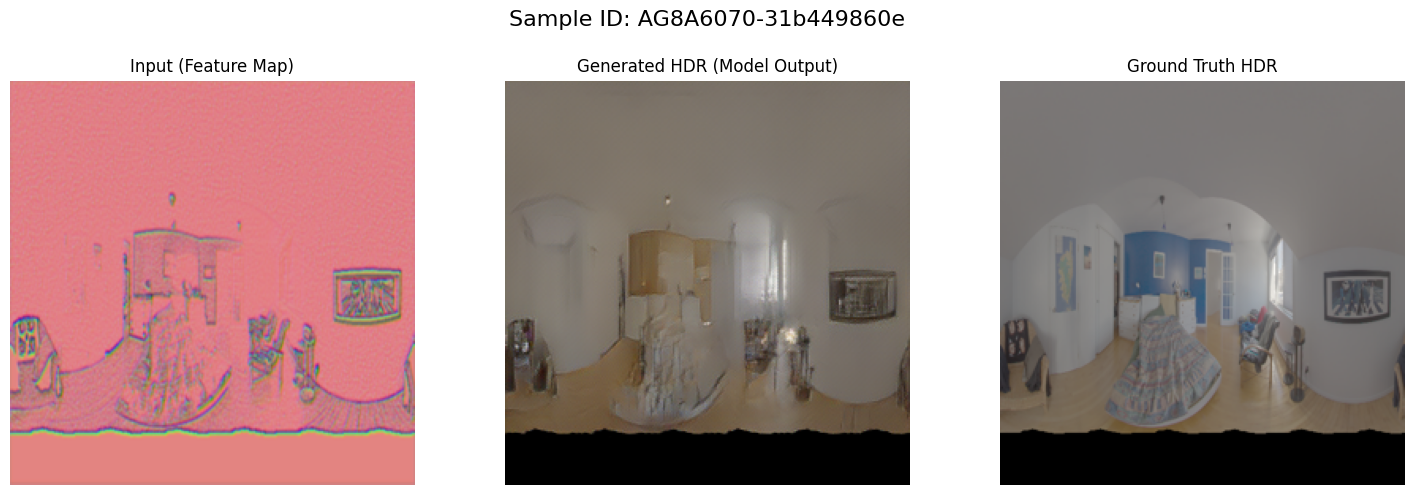

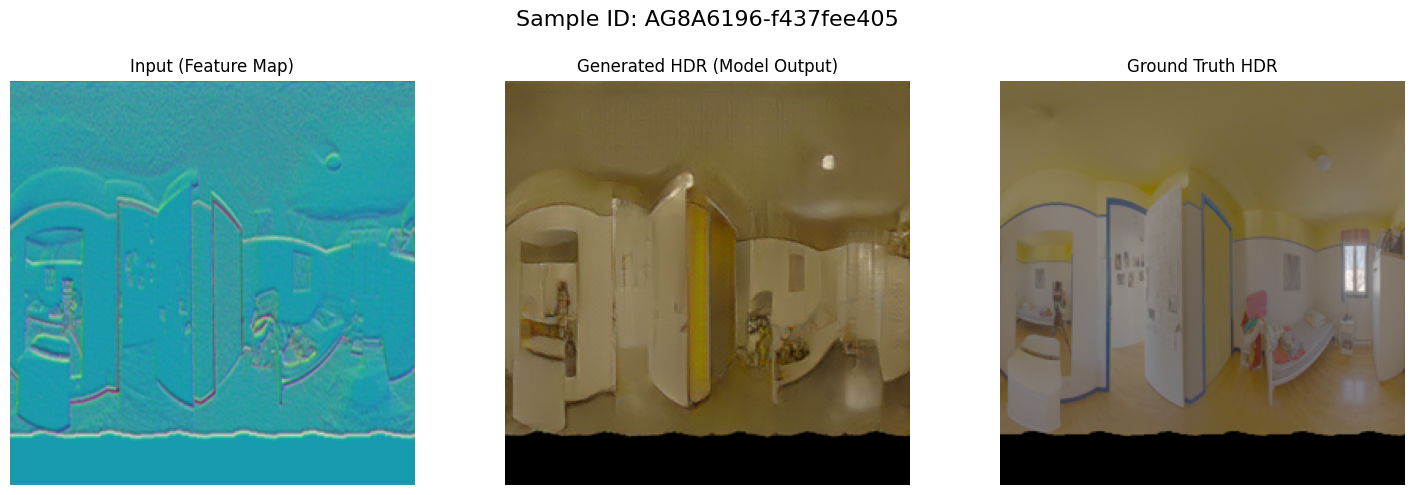

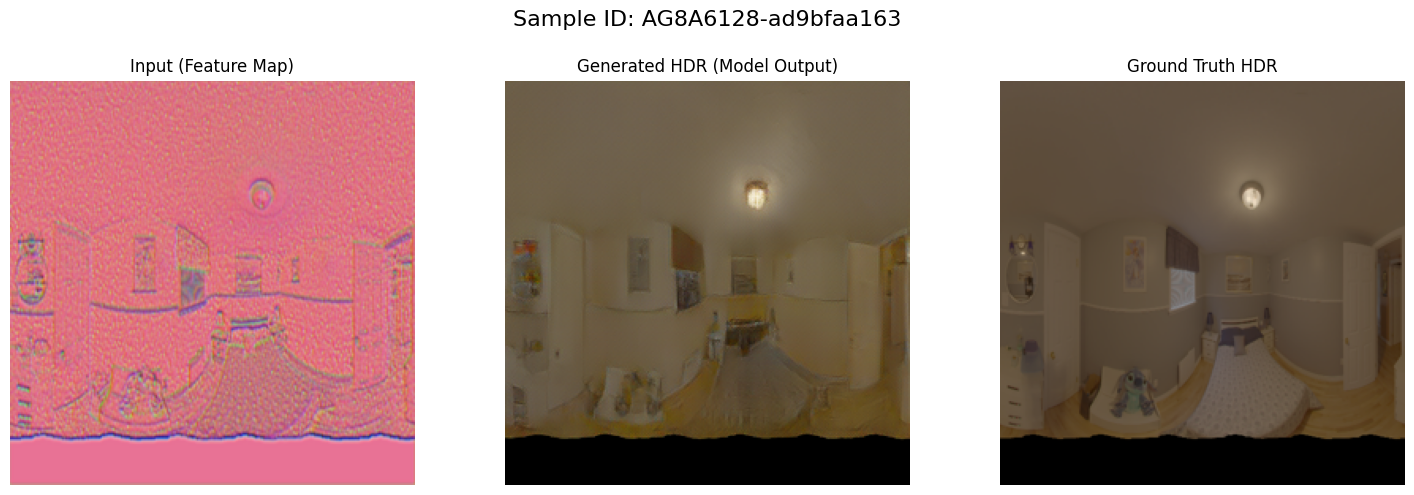

In [ ]:
# Robust display cell: correct id extraction, exact file matching, and top suptitle placement
from PIL import Image
import matplotlib.pyplot as plt
import os, random, re

res_dir = "/content/pytorch-CycleGAN-and-pix2pix/pytorch-CycleGAN-and-pix2pix/results/task2_pix2pix/test_latest/images"
all_imgs = sorted([f for f in os.listdir(res_dir) if f.endswith('.png')])
if not all_imgs:
    print("No images found in", res_dir)
else:
    # extract ids by removing suffixes like _fake_B.png, _real_A.png, _fake.png, etc.
    ids = []
    for nm in all_imgs:
        base = re.split(r'(_fake|_real|_fake_A|_fake_B|_real_A|_real_B)', nm)[0]
        if base:
            ids.append(base)
    ids = sorted(list(dict.fromkeys(ids)))  # preserve order, unique

    sample_ids = random.sample(ids, min(3, len(ids)))
    print("Showing sample ids:", sample_ids)

    for sid in sample_ids:
        # exact matching: look for files starting with sid and containing 'fake' or 'real'
        fake = next((f for f in all_imgs if f.startswith(sid) and 'fake' in f), None)
        # allow variants like 'fake', 'fake_B', 'fake_A'
        realA = next((f for f in all_imgs if f.startswith(sid) and 'real_A' in f), None)
        if realA is None:
            realA = next((f for f in all_imgs if f.startswith(sid) and ('real' in f and 'A' in f)), None)
        realB = next((f for f in all_imgs if f.startswith(sid) and 'real_B' in f), None)
        if realB is None:
            realB = next((f for f in all_imgs if f.startswith(sid) and ('real' in f and 'B' in f)), None)

        # Build list to display in correct order: GT, Generated, Input
        display_triplet = []
        labels = []
        for nm, label in [(realA,"Input (Feature Map)"), (fake, "Generated HDR (Model Output)"), (realB,  "Ground Truth HDR")]:
            if nm and os.path.exists(os.path.join(res_dir, nm)):
                display_triplet.append(Image.open(os.path.join(res_dir, nm)).convert("RGB"))
                labels.append(label)

        if len(display_triplet) == 0:
            print(f"No matching images for id {sid}. Files containing sid:")
            print([f for f in all_imgs if sid in f][:10])
            continue

        # Plot with reserved top space for the suptitle (so it displays correctly)
        plt.figure(figsize=(15,5))
        for i, (img, lbl) in enumerate(zip(display_triplet, labels)):
            ax = plt.subplot(1, len(display_triplet), i+1)
            ax.imshow(img)
            ax.set_title(lbl, fontsize=12)
            ax.axis('off')

        # Put suptitle at the top and ensure layout doesn't overlap
        plt.suptitle(f"Sample ID: {sid}", fontsize=16, y=0.98)
        plt.tight_layout(rect=[0, 0, 1, 0.94])
        plt.show()


In [ ]:
!python test.py --dataroot ./datasets/task2_cyc --name task2_cycgan --model cycle_gan --which_epoch latest --results_dir ./results/task2_cycgan --which_direction BtoA


In [ ]:
from IPython.display import Image, display
import glob, os
imgs = sorted(glob.glob("results/task2_pix2pix/test_latest/images/*"))[:12]
for p in imgs:
    display(Image(p))
